In [1]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00041_0000.mid.lz4"
mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Lists to store leading and trailing edges
leading_edges = []
trailing_edges = []

prev_edge = None

# Iterate over all events in the file
for event in mfile:
    if event.header.is_midas_internal_event():
        continue

    if event.header.serial_number > 10000:
      break

    for bank_name in event.banks:
        bank = event.banks[bank_name]
        data = bank.data
        index = 0
        
        while index < len(data):
            # Read header words
            trigger_timestamp = data[index]
            trigger_id = int(data[index + 1])
            header_word2 = int(data[index + 2])
            board_number = (header_word2 >> 32) & 0xFFFFFFFF
            number_of_hits = header_word2 & 0xFFFFFFFF
            
            if trigger_id > 1163400:
              index += 3 + number_of_hits
              continue

            index += 3  # Move past the header words
            
            # Read hit words
            for _ in range(number_of_hits):
                hit_word = int(data[index])
                channel_id, edge, tot, toa = parse_hit_word(hit_word)

                if channel_id == 9:
                  ts_ps = adc2time(toa) + trigger_timestamp*12800

                  if edge == 1:  # leading edge
                    if prev_edge == edge:
                      leading_edges[-1] = ts_ps
                    else:
                      leading_edges.append(ts_ps)
                  elif edge == 0:  # trailing edge
                    if prev_edge == edge:
                      pass
                    elif len(leading_edges) <= len(trailing_edges):
                      pass
                    elif len(leading_edges) and ts_ps < leading_edges[-1]:
                      pass
                    else:
                      trailing_edges.append(ts_ps)
                
                  prev_edge = edge
                index += 1

# Ensure the leading_edges and trailing_edges arrays are of the same length
min_length = min(len(leading_edges), len(trailing_edges))
leading_edges = np.array(leading_edges[:min_length])
trailing_edges = np.array(trailing_edges[:min_length])

# Calculate Time Over Threshold (ToT)
tot = trailing_edges - leading_edges

# Detect peaks in the histogram
counts, bin_edges = np.histogram(tot, bins=1000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=700, distance=100)  # Adjusted height and distance

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]

# Store peak data in arrays
peak_numbers_set1 = np.arange(1, len(peak_centers) + 1)
peak_centers_set1 = peak_centers

# Print the peak data
print("Peak numbers (Set 1):", peak_numbers_set1)
print("Peak centers (Set 1):", peak_centers_set1)

# Clear variables and run garbage collection
del tot
gc.collect()


Peak numbers (Set 1): [1 2]
Peak centers (Set 1): [1558.909375 2210.121875]


0

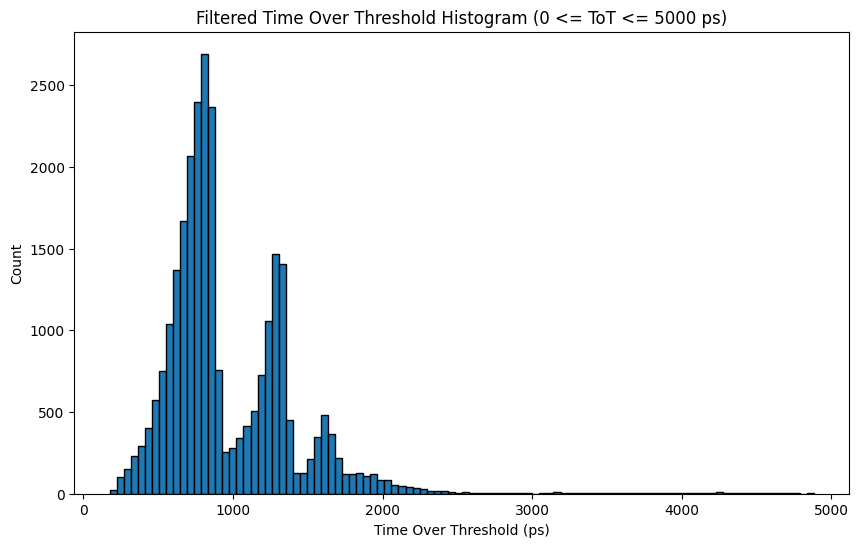

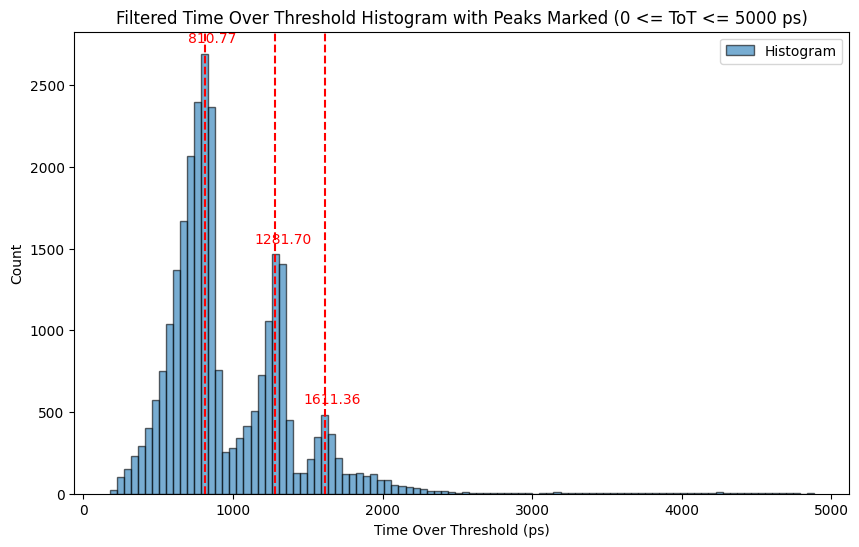

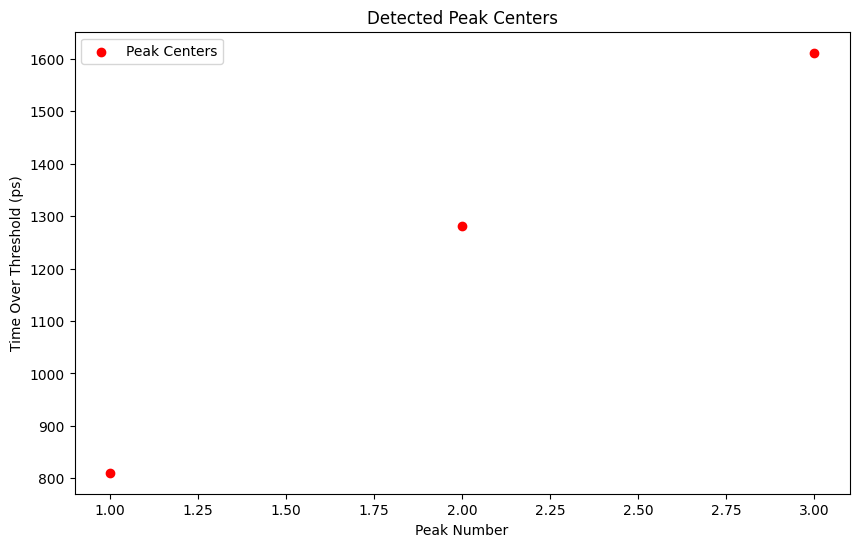

TypeError: exponential() takes 3 positional arguments but 4 were given

In [1]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00044_0000.mid.lz4"

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Process the MIDAS file and extract ToT values
def process_file(fpath):
    mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

    leading_edges = []
    trailing_edges = []

    prev_edge = None

    for event in mfile:
        if event.header.is_midas_internal_event():
            continue
        if event.header.serial_number > 10000:
            break

        for bank_name in event.banks:
            bank = event.banks[bank_name]
            data = bank.data
            index = 0

            while index < len(data):
                trigger_timestamp = data[index]
                trigger_id = int(data[index + 1])
                header_word2 = int(data[index + 2])
                board_number = (header_word2 >> 32) & 0xFFFFFFFF
                number_of_hits = header_word2 & 0xFFFFFFFF

                if trigger_id > 1163400:
                    index += 3 + number_of_hits
                    continue

                index += 3

                for _ in range(number_of_hits):
                    hit_word = int(data[index])
                    channel_id, edge, tot, toa = parse_hit_word(hit_word)

                    if channel_id == 9:
                        ts_ps = adc2time(toa) + trigger_timestamp * 12800

                        if edge == 1:  # leading edge
                            if prev_edge == edge:
                                leading_edges[-1] = ts_ps
                            else:
                                leading_edges.append(ts_ps)
                        elif edge == 0:  # trailing edge
                            if prev_edge == edge:
                                pass
                            elif len(leading_edges) <= len(trailing_edges):
                                pass
                            elif len(leading_edges) and ts_ps < leading_edges[-1]:
                                pass
                            else:
                                trailing_edges.append(ts_ps)

                        prev_edge = edge
                    index += 1

    min_length = min(len(leading_edges), len(trailing_edges))
    leading_edges = np.array(leading_edges[:min_length])
    trailing_edges = np.array(trailing_edges[:min_length])
    tot = trailing_edges - leading_edges

    return tot

# Process the file and get ToT values
tot = process_file(fpath)

# Define the range for filtering ToT values
tot_min = 0                                                                            # Minimum ToT value for the range
tot_max = 5000                                                                           # Maximum ToT value for the range

# Filter the ToT values based on the specified range
filtered_tot = tot[(tot >= tot_min) & (tot <= tot_max)]

# Plot the histogram of filtered Time Over Threshold (ToT)
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(filtered_tot, bins=100, edgecolor='black')
plt.title(f"Filtered Time Over Threshold Histogram ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")

# Detect peaks in the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=200, distance=5)                 # Adjusted height and distance to match the parent code

# Mark the detected peaks with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Histogram')
for peak in peaks:
    plt.axvline(bin_centers[peak], color='red', linestyle='--')
    plt.text(bin_centers[peak]+50, counts[peak]+50, f'{bin_centers[peak]:.2f}', color='red', ha='center', va='bottom')       #################

plt.title(f"Filtered Time Over Threshold Histogram with Peaks Marked ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]
peak_counts = counts[peaks]

# Number the peaks (starting from 3)
peak_numbers = np.arange(1, len(peak_centers) + 1)

# Plot the peak centers separately with numbering as the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.title("Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Define the exponential function to fit the peak centers
def exponential(x, a, b):
    return a * np.exp(b * x) 

# Fit the exponential function to the peak centers
popt, pcov = curve_fit(exponential, peak_numbers, peak_centers, p0=(1, -0.001, 0))

# Generate x values for the fitted curve
x_fit = np.linspace(min(peak_numbers), max(peak_numbers), 1000)
y_fit = exponential(x_fit, *popt)

# Calculate the deviations
deviations = peak_centers - exponential(peak_numbers, *popt)

# Plot the peak centers and the fitted curve with error bars for deviations
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.errorbar(peak_numbers, peak_centers, yerr=np.abs(deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(x_fit, y_fit, label='Exponential Fit', color='blue')

# Add labels for the deviations
for i in range(len(peak_numbers)):
    plt.text(peak_numbers[i], peak_centers[i] + np.abs(deviations)[i] + 20, f'{deviations[i]:.2f}', color='black', ha='center')

plt.title("Detected Peak Centers with Exponential Fit and Deviations")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: a={popt[0]}, b={popt[1]}, c={popt[2]}")

# Store peak data in arrays
peak_numbers_set2 = peak_numbers
peak_centers_set2 = peak_centers

# Clear variables and run garbage collection
del tot
gc.collect()


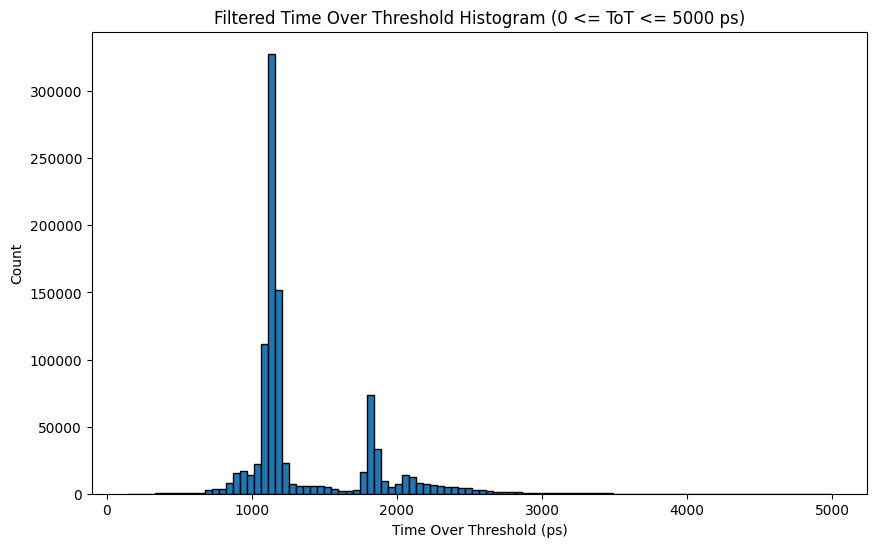

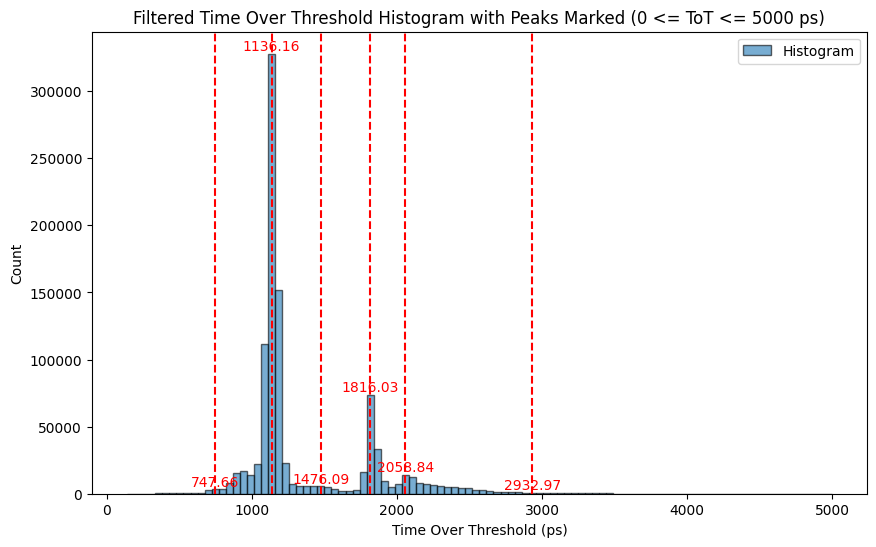

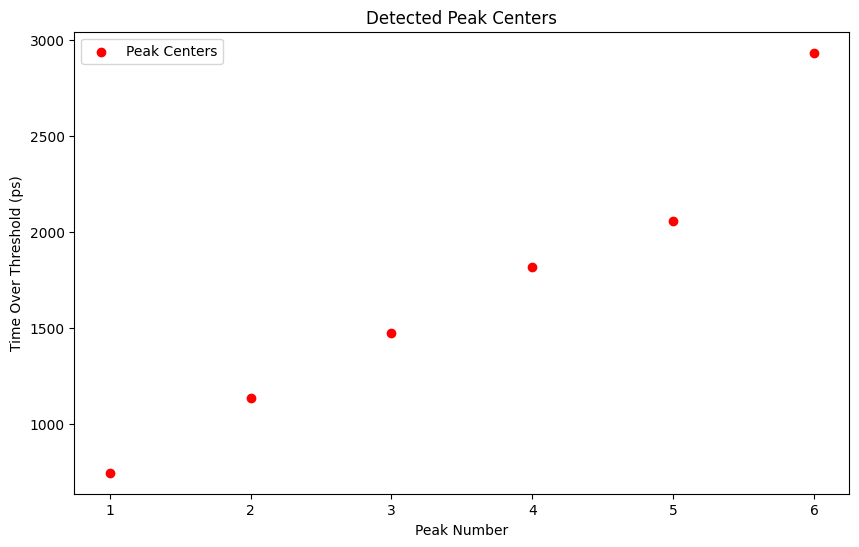

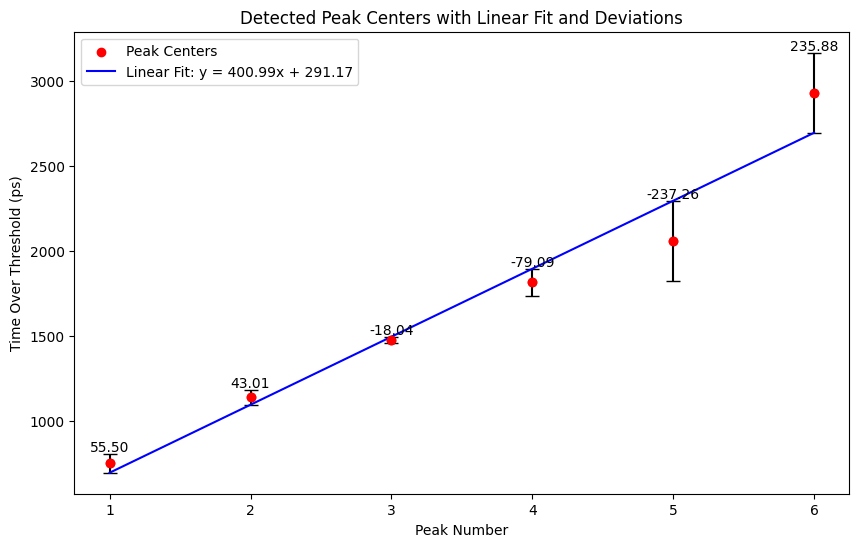

Fitted parameters: m=400.9875009706435, c=291.16874277734996


20873

In [4]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00116_0000.mid.lz4"

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Process the MIDAS file and extract ToT values
def process_file(fpath):
    mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

    leading_edges = []
    trailing_edges = []

    prev_edge = None

    for event in mfile:
        if event.header.is_midas_internal_event():
            continue
        if event.header.serial_number > 10000:
            break

        for bank_name in event.banks:
            bank = event.banks[bank_name]
            data = bank.data
            index = 0

            while index < len(data):
                trigger_timestamp = data[index]
                trigger_id = int(data[index + 1])
                header_word2 = int(data[index + 2])
                board_number = (header_word2 >> 32) & 0xFFFFFFFF
                number_of_hits = header_word2 & 0xFFFFFFFF

                if trigger_id > 1163400:
                    index += 3 + number_of_hits
                    continue

                index += 3

                for _ in range(number_of_hits):
                    hit_word = int(data[index])
                    channel_id, edge, tot, toa = parse_hit_word(hit_word)

                    if channel_id == 2:
                        ts_ps = adc2time(toa) + trigger_timestamp * 12800

                        if edge == 1:  # leading edge
                            if prev_edge == edge:
                                leading_edges[-1] = ts_ps
                            else:
                                leading_edges.append(ts_ps)
                        elif edge == 0:  # trailing edge
                            if prev_edge == edge:
                                pass
                            elif len(leading_edges) <= len(trailing_edges):
                                pass
                            elif len(leading_edges) and ts_ps < leading_edges[-1]:
                                pass
                            else:
                                trailing_edges.append(ts_ps)

                        prev_edge = edge
                    index += 1

    min_length = min(len(leading_edges), len(trailing_edges))
    leading_edges = np.array(leading_edges[:min_length])
    trailing_edges = np.array(trailing_edges[:min_length])
    tot = trailing_edges - leading_edges

    return tot

# Process the file and get ToT values
tot = process_file(fpath)

# Define the range for filtering ToT values
tot_min = 0                                                                # Minimum ToT value for the range
tot_max = 5000                                                                # Maximum ToT value for the range

# Filter the ToT values based on the specified range
filtered_tot = tot[(tot >= tot_min) & (tot <= tot_max)]

# Plot the histogram of filtered Time Over Threshold (ToT)
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(filtered_tot, bins=100, edgecolor='black')
plt.title(f"Filtered Time Over Threshold Histogram ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")

# Detect peaks in the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=500, distance=5)                  # Adjusted height and distance to match the parent code

# Mark the detected peaks with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Histogram')
for peak in peaks:
    plt.axvline(bin_centers[peak], color='red', linestyle='--')
    plt.text(bin_centers[peak], counts[peak], f'{bin_centers[peak]:.2f}', color='red', ha='center', va='bottom')

plt.title(f"Filtered Time Over Threshold Histogram with Peaks Marked ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]
peak_counts = counts[peaks]

# Number the peaks (starting from 1)
peak_numbers = np.arange(1, len(peak_centers) + 1)

# Plot the peak centers separately with numbering as the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.title("Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Define the linear function to fit the peak centers
def linear(x, m, c):
    return m * x + c

# Fit the linear function to the peak centers
popt, pcov = curve_fit(linear, peak_numbers, peak_centers)

# Generate x values for the fitted curve
x_fit = np.linspace(min(peak_numbers), max(peak_numbers), 1000)
y_fit = linear(x_fit, *popt)

# Calculate the deviations
deviations = peak_centers - linear(peak_numbers, *popt)

# Plot the peak centers and the fitted curve with error bars for deviations
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.errorbar(peak_numbers, peak_centers, yerr=np.abs(deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(x_fit, y_fit, label=f'Linear Fit: y = {popt[0]:.2f}x + {popt[1]:.2f}', color='blue')

# Add labels for the deviations
for i in range(len(peak_numbers)):
    plt.text(peak_numbers[i], peak_centers[i] + np.abs(deviations)[i] +15 , f'{deviations[i]:.2f}', color='black', ha='center')

plt.title("Detected Peak Centers with Linear Fit and Deviations")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: m={popt[0]}, c={popt[1]}")

# Store peak data in arrays
peak_numbers_set2 = peak_numbers
peak_centers_set2 = peak_centers

# Clear variables and run garbage collection
del tot
gc.collect()

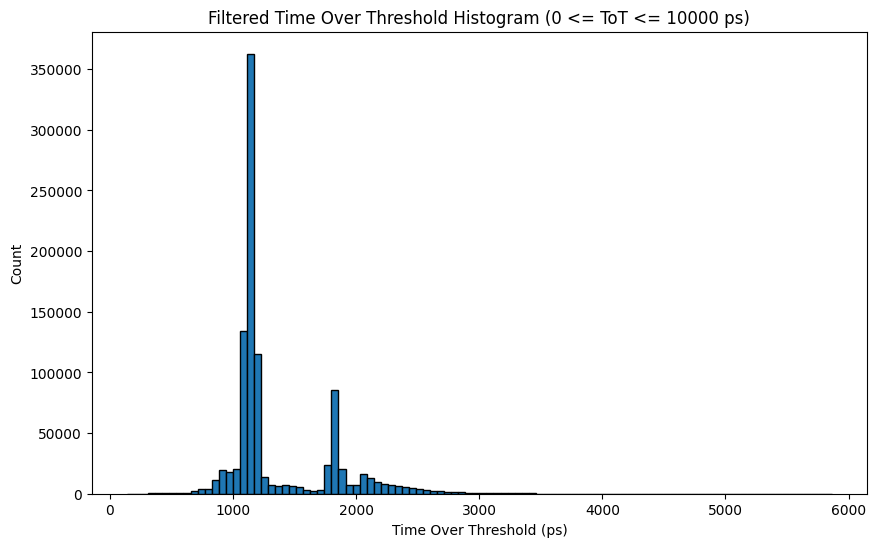

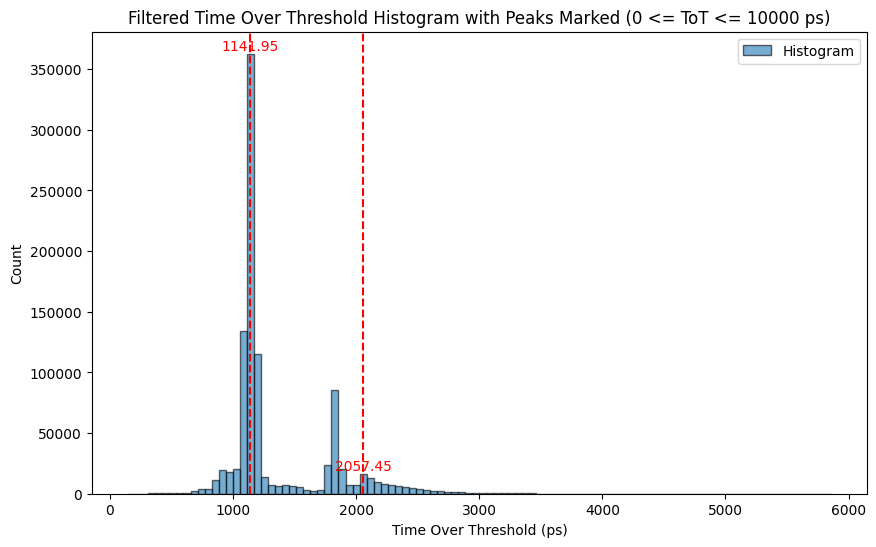

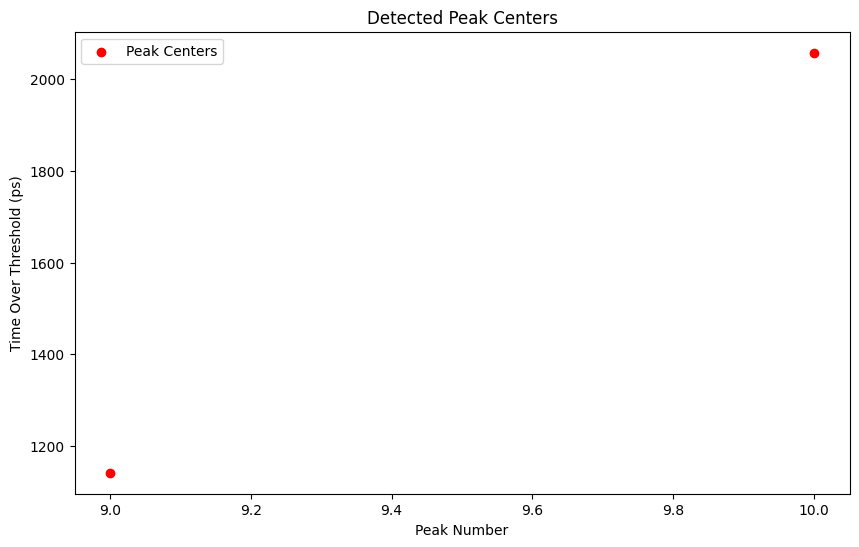

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28836\3659178821.py:147: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, peak_numbers, peak_centers)


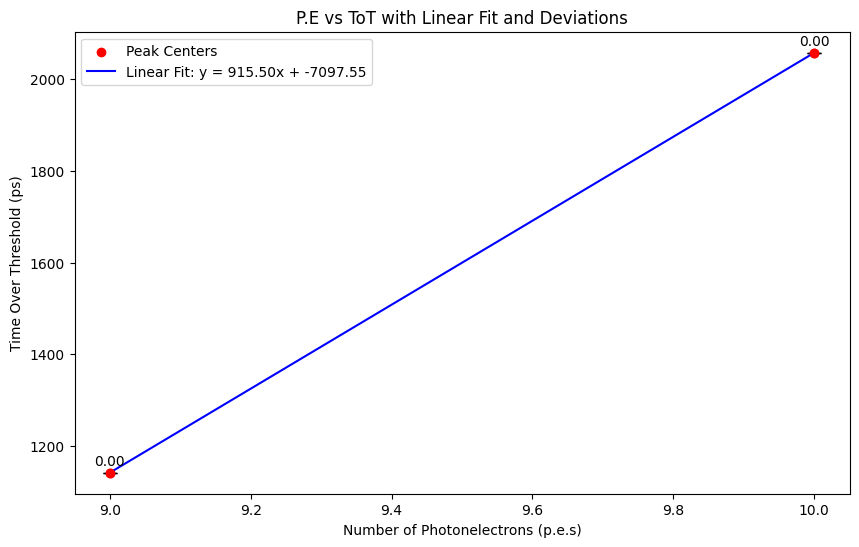

Fitted parameters: m=915.4999999999998, c=-7097.546874999998


23322

In [2]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00116_0000.mid.lz4"

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Process the MIDAS file and extract ToT values
def process_file(fpath):
    mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

    leading_edges = []
    trailing_edges = []

    prev_edge = None

    for event in mfile:
        if event.header.is_midas_internal_event():
            continue
        if event.header.serial_number > 10000:
            break

        for bank_name in event.banks:
            bank = event.banks[bank_name]
            data = bank.data
            index = 0

            while index < len(data):
                trigger_timestamp = data[index]
                trigger_id = int(data[index + 1])
                header_word2 = int(data[index + 2])
                board_number = (header_word2 >> 32) & 0xFFFFFFFF
                number_of_hits = header_word2 & 0xFFFFFFFF

                if trigger_id > 1163400:
                    index += 3 + number_of_hits
                    continue

                index += 3

                for _ in range(number_of_hits):
                    hit_word = int(data[index])
                    channel_id, edge, tot, toa = parse_hit_word(hit_word)

                    if channel_id == 2:
                        ts_ps = adc2time(toa) + trigger_timestamp * 12800

                        if edge == 1:  # leading edge
                            if prev_edge == edge:
                                leading_edges[-1] = ts_ps
                            else:
                                leading_edges.append(ts_ps)
                        elif edge == 0:  # trailing edge
                            if prev_edge == edge:
                                pass
                            elif len(leading_edges) <= len(trailing_edges):
                                pass
                            elif len(leading_edges) and ts_ps < leading_edges[-1]:
                                pass
                            else:
                                trailing_edges.append(ts_ps)

                        prev_edge = edge
                    index += 1

    min_length = min(len(leading_edges), len(trailing_edges))
    leading_edges = np.array(leading_edges[:min_length])
    trailing_edges = np.array(trailing_edges[:min_length])
    tot = trailing_edges - leading_edges

    return tot

# Process the file and get ToT values
tot = process_file(fpath)

# Define the range for filtering ToT values
tot_min = 0                                                                # Minimum ToT value for the range
tot_max = 10000                                                                # Maximum ToT value for the range

# Filter the ToT values based on the specified range
filtered_tot = tot[(tot >= tot_min) & (tot <= tot_max)]

# Plot the histogram of filtered Time Over Threshold (ToT)
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(filtered_tot, bins=100, edgecolor='black')
plt.title(f"Filtered Time Over Threshold Histogram ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")

# Detect peaks in the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=150, distance=14)                  # Adjusted height and distance to match the parent code

# Mark the detected peaks with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Histogram')
for peak in peaks:
    plt.axvline(bin_centers[peak], color='red', linestyle='--')
    plt.text(bin_centers[peak], counts[peak], f'{bin_centers[peak]:.2f}', color='red', ha='center', va='bottom')

plt.title(f"Filtered Time Over Threshold Histogram with Peaks Marked ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]
peak_counts = counts[peaks]

                                                                                               # Define the offset for peak numbering
peak_offset = 9

# Number the peaks (starting from the offset value)
peak_numbers = np.arange(peak_offset, peak_offset + len(peak_centers))

# Plot the peak centers separately with numbering as the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.title("Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Define the linear function to fit the peak centers
def linear(x, m, c):
    return m * x + c

# Fit the linear function to the peak centers
popt, pcov = curve_fit(linear, peak_numbers, peak_centers)

# Generate x values for the fitted curve
x_fit = np.linspace(min(peak_numbers), max(peak_numbers), 1000)
y_fit = linear(x_fit, *popt)

# Calculate the deviations
deviations = peak_centers - linear(peak_numbers, *popt)

# Plot the peak centers and the fitted curve with error bars for deviations
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.errorbar(peak_numbers, peak_centers, yerr=np.abs(deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(x_fit, y_fit, label=f'Linear Fit: y = {popt[0]:.2f}x + {popt[1]:.2f}', color='blue')

# Add labels for the deviations
for i in range(len(peak_numbers)):
    plt.text(peak_numbers[i], peak_centers[i] + np.abs(deviations)[i] + 15, f'{deviations[i]:.2f}', color='black', ha='center')

plt.title("P.E vs ToT with Linear Fit and Deviations")
plt.xlabel("Number of Photonelectrons (p.e.s)")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: m={popt[0]}, c={popt[1]}")

# Store peak data in arrays
peak_numbers_set2 = peak_numbers
peak_centers_set2 = peak_centers

# Clear variables and run garbage collection
del tot
gc.collect()


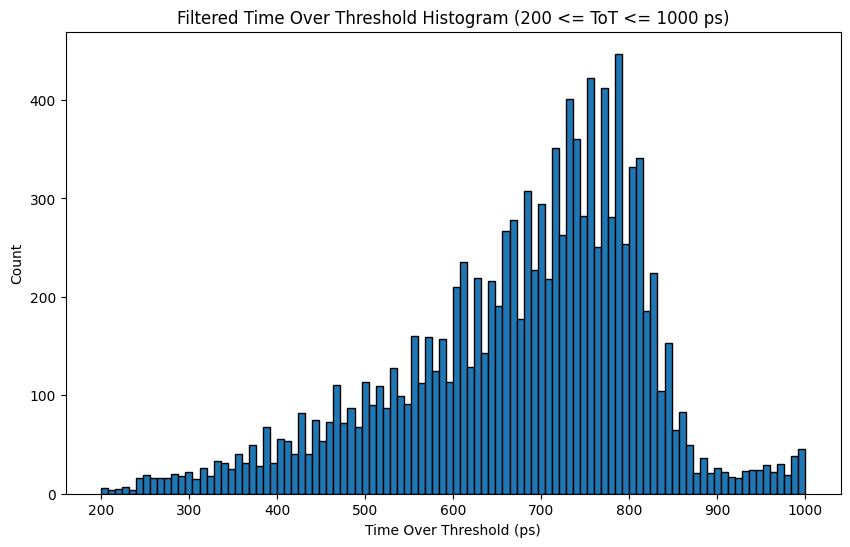

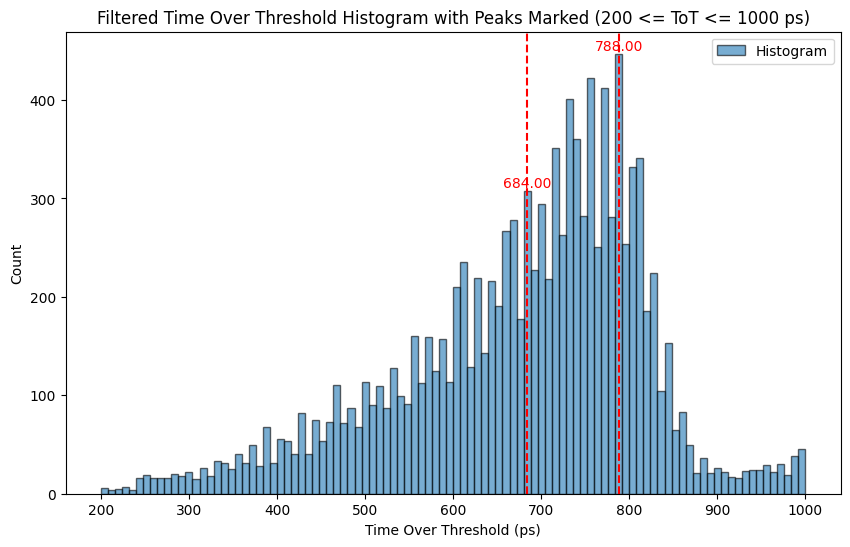

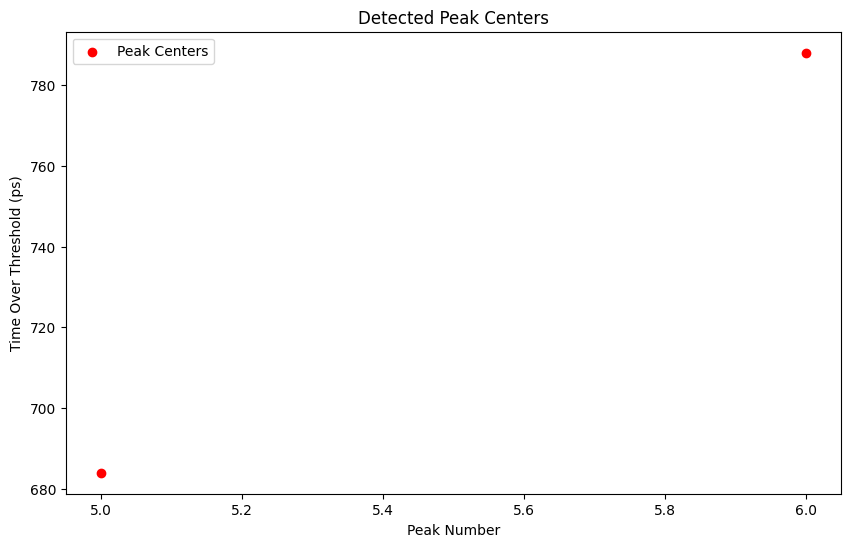

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_43368\3737673696.py:144: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, peak_numbers, peak_centers)


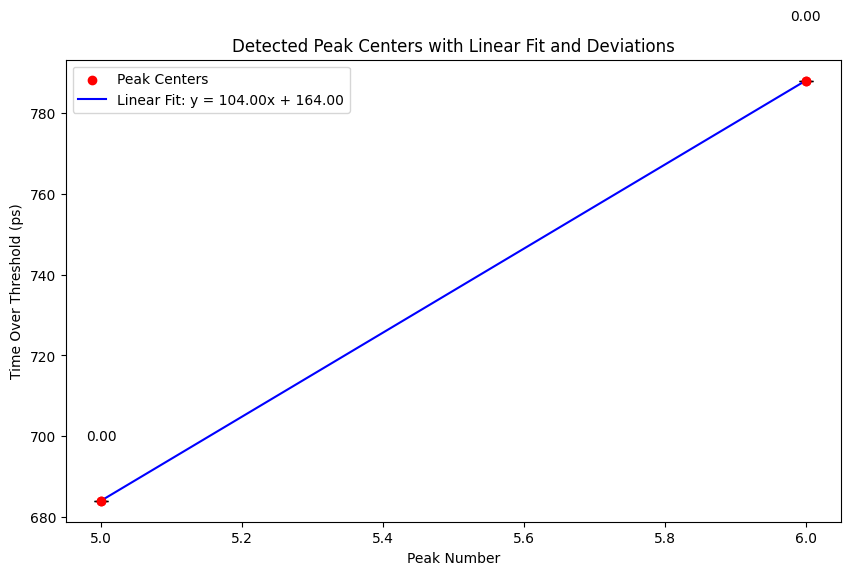

Fitted parameters: m=103.99999999999996, c=164.00000000000023


20108

In [8]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00044_0000.mid.lz4"

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Process the MIDAS file and extract ToT values
def process_file(fpath):
    mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

    leading_edges = []
    trailing_edges = []

    prev_edge = None

    for event in mfile:
        if event.header.is_midas_internal_event():
            continue
        if event.header.serial_number > 10000:
            break

        for bank_name in event.banks:
            bank = event.banks[bank_name]
            data = bank.data
            index = 0

            while index < len(data):
                trigger_timestamp = data[index]
                trigger_id = int(data[index + 1])
                header_word2 = int(data[index + 2])
                board_number = (header_word2 >> 32) & 0xFFFFFFFF
                number_of_hits = header_word2 & 0xFFFFFFFF

                if trigger_id > 1163400:
                    index += 3 + number_of_hits
                    continue

                index += 3

                for _ in range(number_of_hits):
                    hit_word = int(data[index])
                    channel_id, edge, tot, toa = parse_hit_word(hit_word)

                    if channel_id == 10:
                        ts_ps = adc2time(toa) + trigger_timestamp * 12800

                        if edge == 1:  # leading edge
                            if prev_edge == edge:
                                leading_edges[-1] = ts_ps
                            else:
                                leading_edges.append(ts_ps)
                        elif edge == 0:  # trailing edge
                            if prev_edge == edge:
                                pass
                            elif len(leading_edges) <= len(trailing_edges):
                                pass
                            elif len(leading_edges) and ts_ps < leading_edges[-1]:
                                pass
                            else:
                                trailing_edges.append(ts_ps)

                        prev_edge = edge
                    index += 1

    min_length = min(len(leading_edges), len(trailing_edges))
    leading_edges = np.array(leading_edges[:min_length])
    trailing_edges = np.array(trailing_edges[:min_length])
    tot = trailing_edges - leading_edges

    return tot

# Process the file and get ToT values
tot = process_file(fpath)

# Define the range for filtering ToT values
tot_min = 200                                                                # Minimum ToT value for the range
tot_max = 1000                                                                # Maximum ToT value for the range

# Filter the ToT values based on the specified range
filtered_tot = tot[(tot >= tot_min) & (tot <= tot_max)]

# Plot the histogram of filtered Time Over Threshold (ToT)
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(filtered_tot, bins=100, edgecolor='black')
plt.title(f"Filtered Time Over Threshold Histogram ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")

# Detect peaks in the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=270, distance=10)                  # Adjusted height and distance to match the parent code

# Mark the detected peaks with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Histogram')
for peak in peaks:
    plt.axvline(bin_centers[peak], color='red', linestyle='--')
    plt.text(bin_centers[peak], counts[peak], f'{bin_centers[peak]:.2f}', color='red', ha='center', va='bottom')

plt.title(f"Filtered Time Over Threshold Histogram with Peaks Marked ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]
peak_counts = counts[peaks]

                                                                                                      # Number the peaks starting from 4
peak_numbers = np.arange(5, len(peak_centers) + 5)

# Plot the peak centers separately with numbering as the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.title("Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Define the linear function to fit the peak centers
def linear(x, m, c):
    return m * x + c

# Fit the linear function to the peak centers
popt, pcov = curve_fit(linear, peak_numbers, peak_centers)

# Generate x values for the fitted curve
x_fit = np.linspace(min(peak_numbers), max(peak_numbers), 1000)
y_fit = linear(x_fit, *popt)

# Calculate the deviations
deviations = peak_centers - linear(peak_numbers, *popt)

# Plot the peak centers and the fitted curve with error bars for deviations
plt.figure(figsize=(10, 6))
plt.scatter(peak_numbers, peak_centers, color='red', label='Peak Centers')
plt.errorbar(peak_numbers, peak_centers, yerr=np.abs(deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(x_fit, y_fit, label=f'Linear Fit: y = {popt[0]:.2f}x + {popt[1]:.2f}', color='blue')

# Add labels for the deviations
for i in range(len(peak_numbers)):
    plt.text(peak_numbers[i], peak_centers[i] + np.abs(deviations)[i] + 15, f'{deviations[i]:.2f}', color='black', ha='center')

plt.title("Detected Peak Centers with Linear Fit and Deviations")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: m={popt[0]}, c={popt[1]}")

# Store peak data in arrays
peak_numbers_set2 = peak_numbers
peak_centers_set2 = peak_centers

# Clear variables and run garbage collection
del tot
gc.collect()


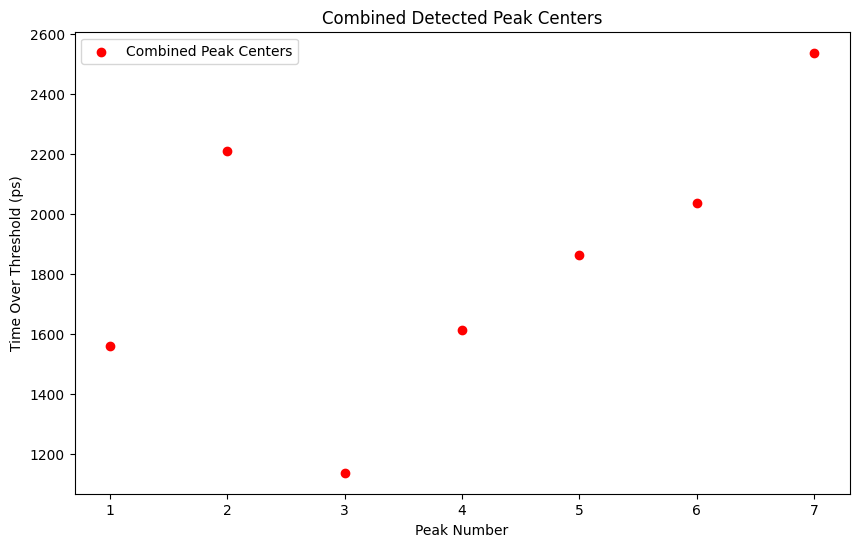

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the peak data from both sets
combined_peak_numbers = np.concatenate((peak_numbers_set1, peak_numbers_set2))
combined_peak_centers = np.concatenate((peak_centers_set1, peak_centers_set2))

# Plot the combined data
plt.figure(figsize=(10, 6))
plt.scatter(combined_peak_numbers, combined_peak_centers, color='red', label='Combined Peak Centers')
plt.title("Combined Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()


In [5]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00041_0000.mid.lz4"
mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Lists to store leading and trailing edges
leading_edges = []
trailing_edges = []

prev_edge = None

# Iterate over all events in the file
for event in mfile:
    if event.header.is_midas_internal_event():
        continue

    if event.header.serial_number > 10000:
      break

    for bank_name in event.banks:
        bank = event.banks[bank_name]
        data = bank.data
        index = 0
        
        while index < len(data):
            # Read header words
            trigger_timestamp = data[index]
            trigger_id = int(data[index + 1])
            header_word2 = int(data[index + 2])
            board_number = (header_word2 >> 32) & 0xFFFFFFFF
            number_of_hits = header_word2 & 0xFFFFFFFF
            
            if trigger_id > 1163400:
              index += 3 + number_of_hits
              continue

            index += 3  # Move past the header words
            
            # Read hit words
            for _ in range(number_of_hits):
                hit_word = int(data[index])
                channel_id, edge, tot, toa = parse_hit_word(hit_word)

                if channel_id == 9:
                  ts_ps = adc2time(toa) + trigger_timestamp*12800

                  if edge == 1:  # leading edge
                    if prev_edge == edge:
                      leading_edges[-1] = ts_ps
                    else:
                      leading_edges.append(ts_ps)
                  elif edge == 0:  # trailing edge
                    if prev_edge == edge:
                      pass
                    elif len(leading_edges) <= len(trailing_edges):
                      pass
                    elif len(leading_edges) and ts_ps < leading_edges[-1]:
                      pass
                    else:
                      trailing_edges.append(ts_ps)
                
                  prev_edge = edge
                index += 1

# Ensure the leading_edges and trailing_edges arrays are of the same length
min_length = min(len(leading_edges), len(trailing_edges))
leading_edges = np.array(leading_edges[:min_length])
trailing_edges = np.array(trailing_edges[:min_length])

# Calculate Time Over Threshold (ToT)
tot = trailing_edges - leading_edges

# Detect peaks in the histogram
counts, bin_edges = np.histogram(tot, bins=1000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=700, distance=100)  # Adjusted height and distance

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]

# Store peak data in arrays with new indexing
peak_numbers_set1 = np.array([2, 6])
peak_centers_set1 = peak_centers

# Print the peak data
print("Peak numbers (Set 1):", peak_numbers_set1)
print("Peak centers (Set 1):", peak_centers_set1)

# Clear variables and run garbage collection
del tot
gc.collect()


Peak numbers (Set 1): [2 6]
Peak centers (Set 1): [1558.909375 2210.121875]


7975

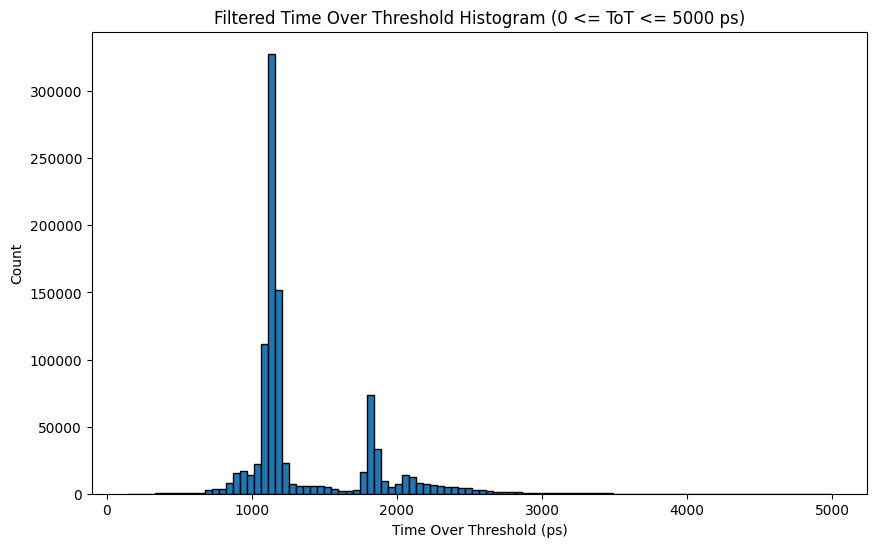

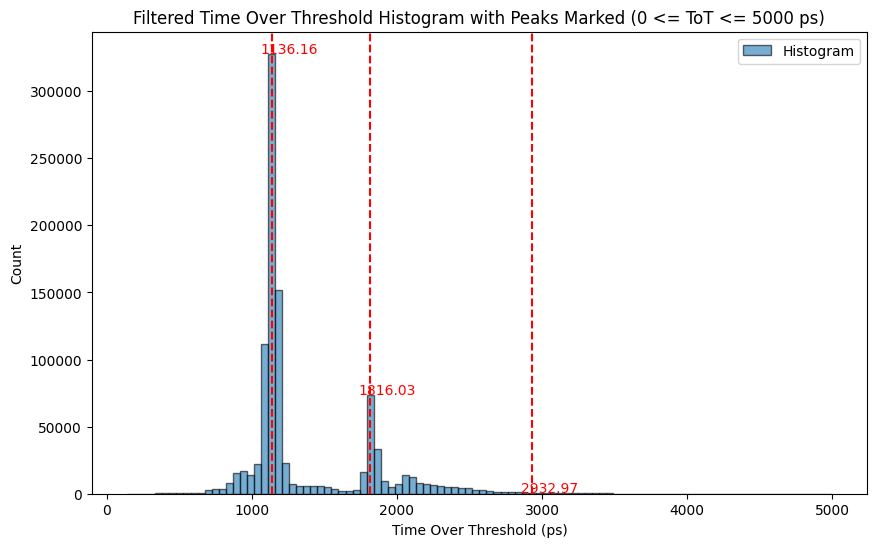

Peak numbers (Set 2): [1 2 3]
Peak centers (Set 2): [1136.15625 1816.03125 2932.96875]


28070

In [15]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import gc

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00116_0000.mid.lz4"

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Process the MIDAS file and extract ToT values
def process_file(fpath):
    mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

    leading_edges = []
    trailing_edges = []

    prev_edge = None

    for event in mfile:
        if event.header.is_midas_internal_event():
            continue
        if event.header.serial_number > 10000:
            break

        for bank_name in event.banks:
            bank = event.banks[bank_name]
            data = bank.data
            index = 0

            while index < len(data):
                trigger_timestamp = data[index]
                trigger_id = int(data[index + 1])
                header_word2 = int(data[index + 2])
                board_number = (header_word2 >> 32) & 0xFFFFFFFF
                number_of_hits = header_word2 & 0xFFFFFFFF

                if trigger_id > 1163400:
                    index += 3 + number_of_hits
                    continue

                index += 3

                for _ in range(number_of_hits):
                    hit_word = int(data[index])
                    channel_id, edge, tot, toa = parse_hit_word(hit_word)

                    if channel_id == 2 :                                    #channel id
                        ts_ps = adc2time(toa) + trigger_timestamp * 12800

                        if edge == 1:  # leading edge
                            if prev_edge == edge:
                                leading_edges[-1] = ts_ps
                            else:
                                leading_edges.append(ts_ps)
                        elif edge == 0:  # trailing edge
                            if prev_edge == edge:
                                pass
                            elif len(leading_edges) <= len(trailing_edges):
                                pass
                            elif len(leading_edges) and ts_ps < leading_edges[-1]:
                                pass
                            else:
                                trailing_edges.append(ts_ps)

                        prev_edge = edge
                    index += 1

    min_length = min(len(leading_edges), len(trailing_edges))
    leading_edges = np.array(leading_edges[:min_length])
    trailing_edges = np.array(trailing_edges[:min_length])
    tot = trailing_edges - leading_edges

    return tot

# Process the file and get ToT values
tot = process_file(fpath)

# Define the range for filtering ToT values
tot_min = 00                                                        # Minimum ToT value for the range
tot_max = 5000                                                        # Maximum ToT value for the range

# Filter the ToT values based on the specified range
filtered_tot = tot[(tot >= tot_min) & (tot <= tot_max)]

# Plot the histogram of filtered Time Over Threshold (ToT)
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(filtered_tot, bins=100, edgecolor='black')
plt.title(f"Filtered Time Over Threshold Histogram ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")

# Detect peaks in the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(counts, height=500, distance=10)  # Adjusted height and distance to match the parent code

# Mark the detected peaks with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Histogram')
for peak in peaks:
    plt.axvline(bin_centers[peak], color='red', linestyle='--')
    plt.text(bin_centers[peak] + 120, counts[peak], f'{bin_centers[peak]:.2f}', color='red', ha='center')  # Adjusted x coordinate

plt.title(f"Filtered Time Over Threshold Histogram with Peaks Marked ({tot_min} <= ToT <= {tot_max} ps)")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Extract the centers of the bars at the peak positions
peak_centers = bin_centers[peaks]
peak_counts = counts[peaks]

# Store peak data in arrays with new indexing
peak_numbers_set2 = np.array([1, 2, 3])
peak_centers_set2 = peak_centers

# Print the peak data
print("Peak numbers (Set 2):", peak_numbers_set2)
print("Peak centers (Set 2):", peak_centers_set2)


# Clear variables and run garbage collection
del tot
gc.collect()


[2 6 1 2 3]


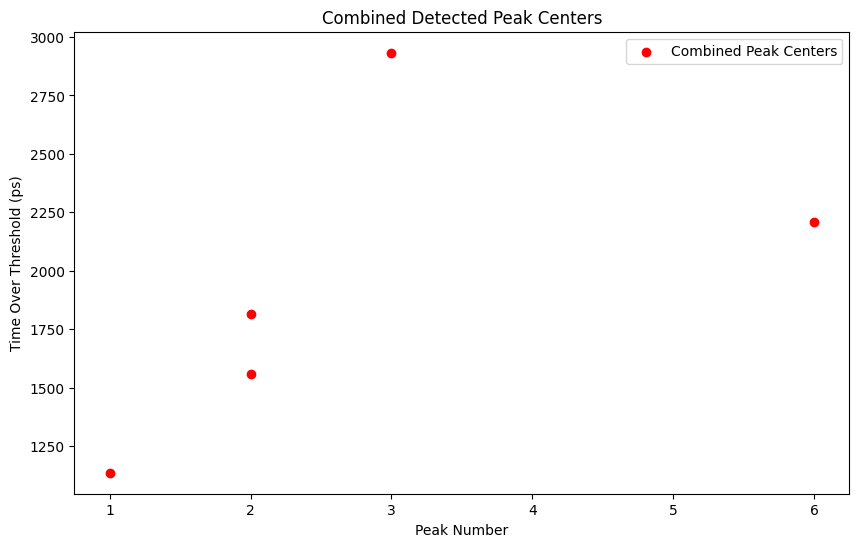

In [16]:
# import matplotlib.pyplot as plt
import numpy as np

# Combine the peak data from both sets
combined_peak_numbers = np.concatenate((peak_numbers_set1, peak_numbers_set2))
combined_peak_centers = np.concatenate((peak_centers_set1, peak_centers_set2))

print(combined_peak_numbers)

# Plot the combined data
plt.figure(figsize=(10, 6))
plt.scatter(combined_peak_numbers, combined_peak_centers, color='red', label='Combined Peak Centers')
plt.title("Combined Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()
plt.show()


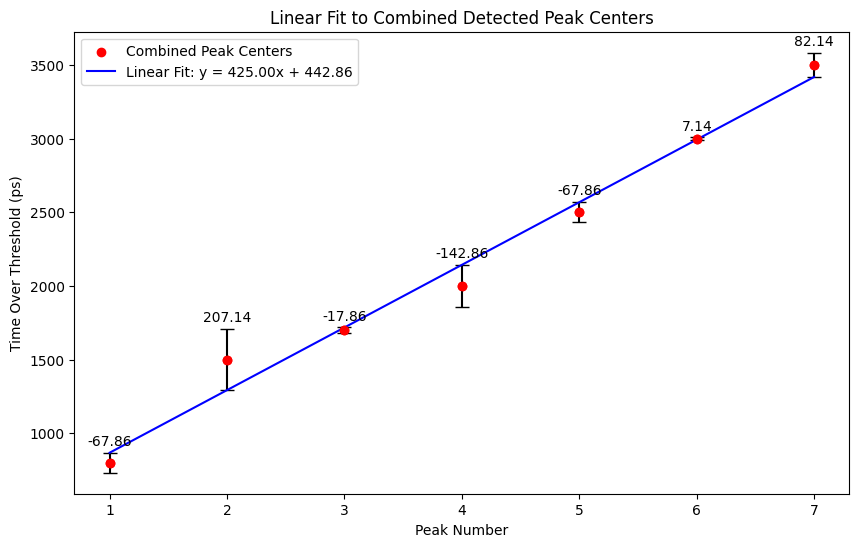

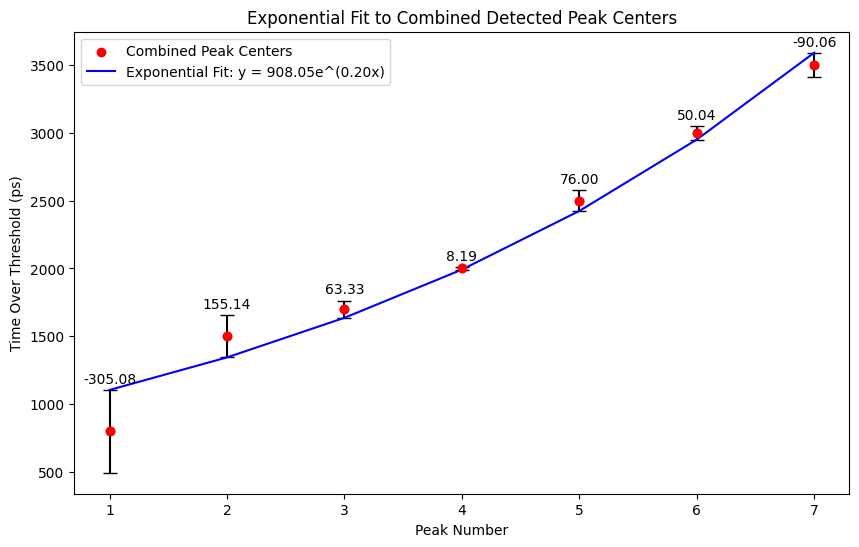

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Sample data
peak_numbers_set1 = np.array([2, 6])
peak_centers_set1 = np.array([1500, 3000])  # Replace with actual data

peak_numbers_set2 = np.array([1, 3, 4, 5, 7])
peak_centers_set2 = np.array([800, 1700, 2000, 2500, 3500])  # Replace with actual data

# Combine the peak data from both sets
combined_peak_numbers = np.concatenate((peak_numbers_set1, peak_numbers_set2))
combined_peak_centers = np.concatenate((peak_centers_set1, peak_centers_set2))

# Sort the combined data by peak numbers
sorted_indices = np.argsort(combined_peak_numbers)
combined_peak_numbers = combined_peak_numbers[sorted_indices]
combined_peak_centers = combined_peak_centers[sorted_indices]

# Linear fit function
def linear(x, m, c):
    return m * x + c

# Exponential fit function
def exponential(x, a, b):
    return a * np.exp(b * x)

# Perform linear fit
linear_params, linear_covariance = curve_fit(linear, combined_peak_numbers, combined_peak_centers)
linear_fit = linear(combined_peak_numbers, *linear_params)

# Perform exponential fit
exp_params, exp_covariance = curve_fit(exponential, combined_peak_numbers, combined_peak_centers)
exp_fit = exponential(combined_peak_numbers, *exp_params)

# Calculate deviations for linear fit
linear_deviations = combined_peak_centers - linear_fit

# Calculate deviations for exponential fit
exp_deviations = combined_peak_centers - exp_fit

# Plot linear fit
plt.figure(figsize=(10, 6))
plt.scatter(combined_peak_numbers, combined_peak_centers, color='red', label='Combined Peak Centers')
plt.errorbar(combined_peak_numbers, combined_peak_centers, yerr=np.abs(linear_deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(combined_peak_numbers, linear_fit, label=f'Linear Fit: y = {linear_params[0]:.2f}x + {linear_params[1]:.2f}', color='blue')
plt.title("Linear Fit to Combined Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()

# Add labels for the deviations
for i in range(len(combined_peak_numbers)):
    plt.text(combined_peak_numbers[i], combined_peak_centers[i] + np.abs(linear_deviations)[i] + 50, f'{linear_deviations[i]:.2f}', color='black', ha='center')

plt.show()

# Plot exponential fit
plt.figure(figsize=(10, 6))
plt.scatter(combined_peak_numbers, combined_peak_centers, color='red', label='Combined Peak Centers')
plt.errorbar(combined_peak_numbers, combined_peak_centers, yerr=np.abs(exp_deviations), fmt='o', color='red', ecolor='black', capsize=5)
plt.plot(combined_peak_numbers, exp_fit, label=f'Exponential Fit: y = {exp_params[0]:.2f}e^({exp_params[1]:.2f}x)', color='blue')
plt.title("Exponential Fit to Combined Detected Peak Centers")
plt.xlabel("Peak Number")
plt.ylabel("Time Over Threshold (ps)")
plt.legend()

# Add labels for the deviations
for i in range(len(combined_peak_numbers)):
    plt.text(combined_peak_numbers[i], combined_peak_centers[i] + np.abs(exp_deviations)[i] + 50, f'{exp_deviations[i]:.2f}', color='black', ha='center')

plt.show()
